In [1]:
from segment_anything import automatic_mask_generator, SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from skimage import io
#import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
im =io.imread("images/blobs.png")
#im_rgb = np.dstack((im, im, im))
sam=sam_model_registry["vit_b"]("sam_b.pt")
sam.to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam,points_per_side=64)
masks = mask_generator.generate(im)


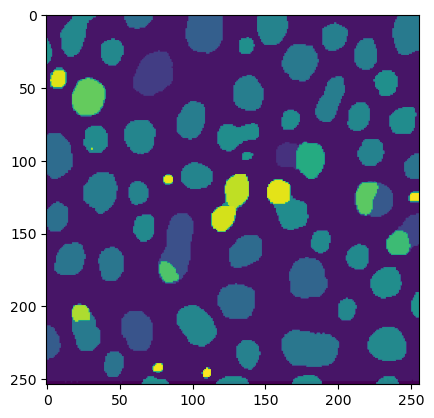

In [5]:
def primesieve(n):
    # Adapted from https://www.quora.com/What-is-the-most-efficient-way-to-generate-a-list-of-all-primes-up-to-some-number-in-Python
    # Generates the first `n` primes starting from 2 via the sieve of Erastothenes.
    # There are 1229 primes under 10000, so start with that.
    # I'm not going to pretend this is good code.

    def _prime_gen(numgen=10000):
        primepossibles=np.ones(numgen)
        primepossibles[0]=0  
        primepossibles[1]=0  
        for i in range(2,numgen//2+1): 
           if primepossibles[i]: 
              primepossibles[range(2*i,numgen,i)]=0 
        primes=np.where(primepossibles)[0]
        return(primes)

    primes = _prime_gen()
    a = n*10
    while (len(primes) < n):
        primes = _prime_gen(a)
        a *= 10
    return(primes[0:n])

def masks_to_label(masks):
    '''
    Takes in a list of masks, encodes the masks as a special label image composed of square-free integers.

    Inputs:
        A list of segmentation masks. The output masks can also be used directly from SAM.

    Returns:
        A label image which is made up of only prime numbers and square-free integers.
    '''

    if isinstance(masks[0], dict):
        masks = [mask["segmentation"] for mask in masks]
    
    array_shape = [masks[0].shape[0], masks[0].shape[1]] # Getting the 2D shape
    n_mask = len(masks)
    primes = primesieve(n_mask)
    label_image = np.ones(array_shape, dtype=np.int32) # Creates a label image of zeros

    for enum, mask in enumerate(masks):
         curr_prime = primes[enum]
         mnarray = mask
         label_image[mnarray] *= curr_prime
    return(label_image)

def label_to_masks(label_image):
    '''
    Takes in a label image and decodes the masks by prime factorization.

    Returns:
        A list of boolean masks.
    '''
    numObj = len(np.unique(label_image))
    primes = primesieve(numObj)
    binary_masks = []
    for n in range(numObj):
        if n > len(primes):
            break
        binary_masks.append(label_image%primes[n] == 0)
    return(binary_masks)

label_image = masks_to_label(masks)

fig, axs = plt.subplots(1,1)
axs.imshow(label_image, cmap="viridis", norm="log") # Holy ugly.

In [12]:
label_image.max()

291398

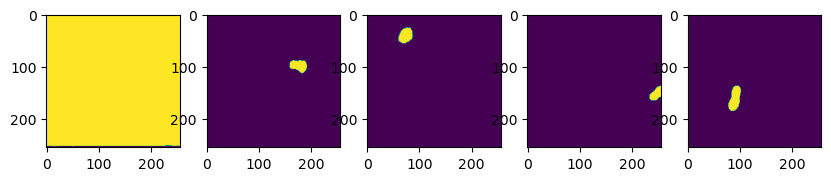

In [9]:
new_masks = label_to_masks(label_image)
fig, axs = plt.subplots(1,5, figsize=(10,10))
for enum, mask in enumerate(new_masks):
    if enum >= 5:
        break
    axs[enum].imshow(mask)